In [57]:
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf
from keras import layers
from keras.optimizers import Adam
import keras

import math
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import yfinance as yf

In [58]:
df= yf.download('TSLA', start='2018-01-01', end='2024-01-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


In [59]:
y=df['Close']
len(df)

1509

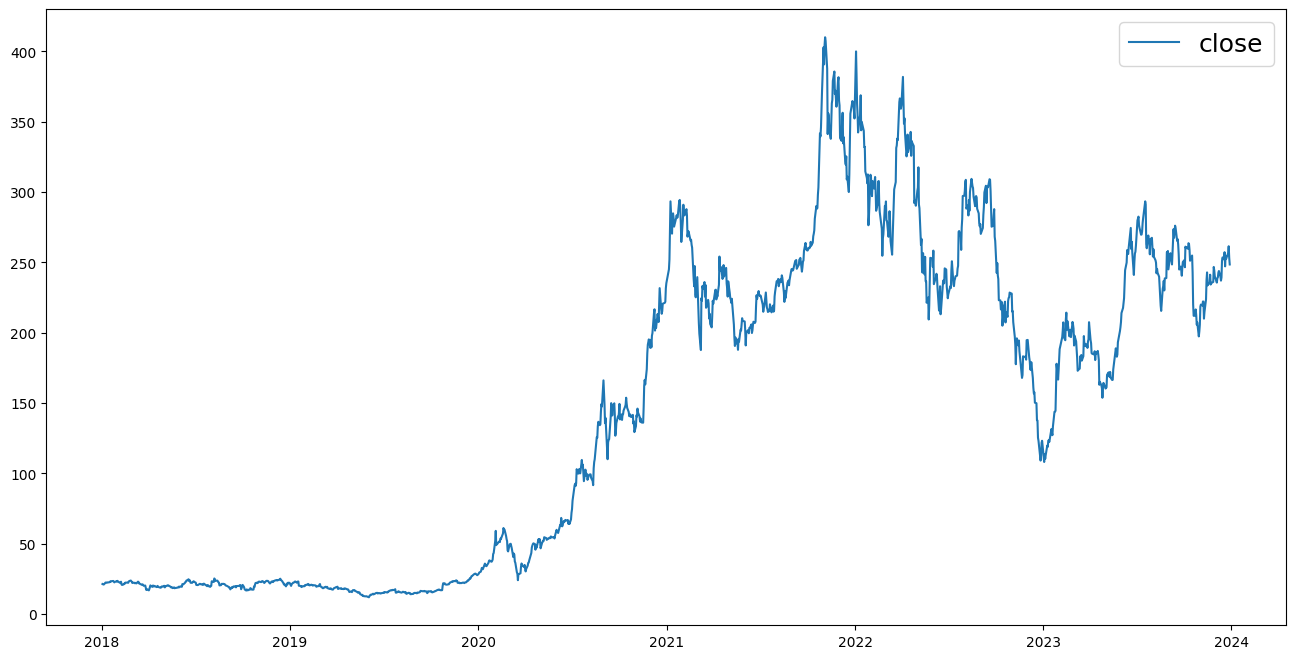

In [60]:
plt.rcParams['figure.figsize'] = (16,8)
x=y.index

plt.plot(x, y, label='close')  

plt.legend(fontsize=18) 
plt.show()  

In [61]:
# 循环神经网络方法训练
look_back=60
Tp = 1200
values = y.values
#归一化
mm = MinMaxScaler()
values=np.reshape(values,(values.shape[0],1))
values=mm.fit_transform(values)
train, test = values[0:Tp], values[Tp:]

In [62]:
def step_ahead(y, jump=1):
    y_current = y[:-(jump + 1), 0]
    y_next = y[jump:-1, 0]
    return np.reshape(y_current, (len(y_current), 1)), np.reshape(y_next, (len(y_next), 1))

In [63]:
look_back = 1
trainXb, trainYb = step_ahead(train, look_back)
testXb, testYb = step_ahead(test, look_back)
trainX = np.reshape(trainXb, (trainXb.shape[0], 1, trainXb.shape[1]))
testX = np.reshape(testXb, (testXb.shape[0], 1, testXb.shape[1]))

In [64]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back)))

model.add(Dense(1))
model.summary()

d:\app\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
and_i_stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainYb, epochs=10, callbacks = [and_i_stop], batch_size=1, verbose=2)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 0.0098
Epoch 2/10
1198/1198 - 1s - 1ms/step - loss: 4.4240e-04
Epoch 3/10
1198/1198 - 1s - 1ms/step - loss: 4.5225e-04
Epoch 4/10
1198/1198 - 1s - 1ms/step - loss: 4.6817e-04
Epoch 5/10
1198/1198 - 1s - 1ms/step - loss: 4.6982e-04
Epoch 6/10
1198/1198 - 1s - 1ms/step - loss: 4.3714e-04
Epoch 7/10
1198/1198 - 1s - 1ms/step - loss: 4.3317e-04
Epoch 8/10
1198/1198 - 1s - 1ms/step - loss: 4.2368e-04
Epoch 9/10
1198/1198 - 1s - 1ms/step - loss: 4.4745e-04
Epoch 10/10
1198/1198 - 1s - 1ms/step - loss: 4.5204e-04


In [66]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#invert predictions
trainPredict = mm.inverse_transform(trainPredict)
trainY = mm.inverse_transform(trainYb)
testPredict = mm.inverse_transform(testPredict)
testY = mm.inverse_transform(testYb)
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 7.94 RMSE
Test Score: 9.24 RMSE


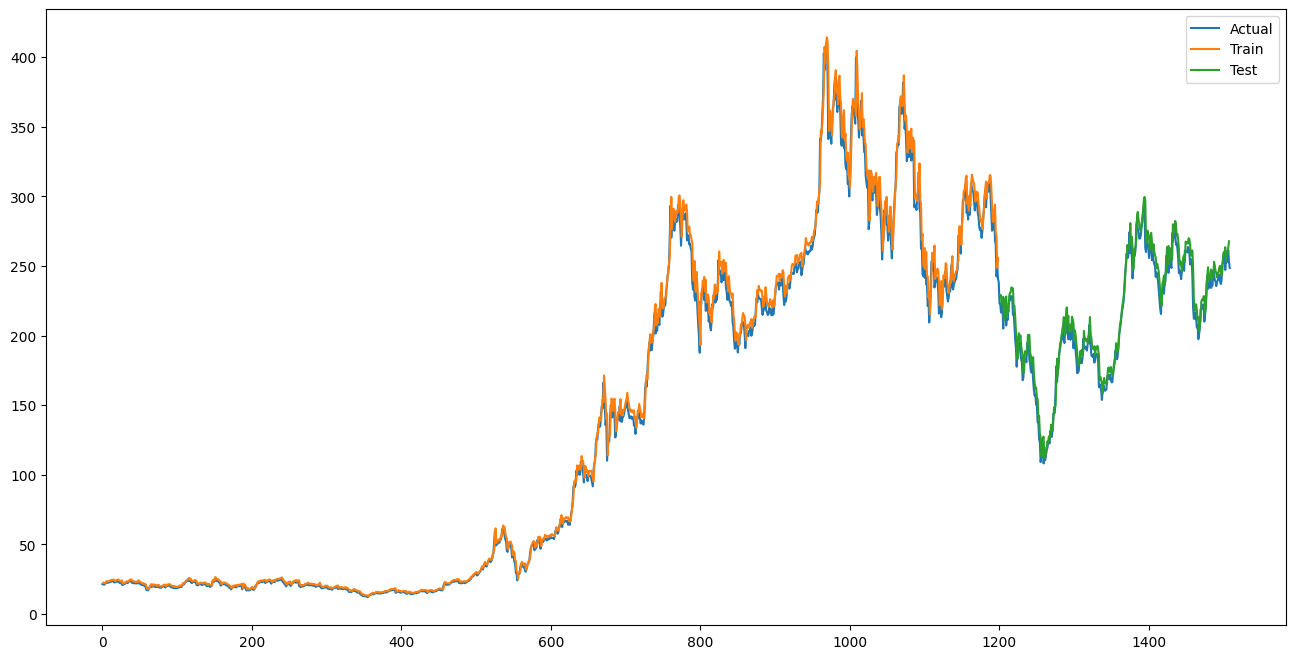

In [67]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#shift test predictions for plotting
testPredictPlot = np.empty_like(values)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(values)-1, :] = testPredict
#plot baseline and predictions
plt.plot(mm.inverse_transform(values),label="Actual")
plt.plot(trainPredictPlot,label="Train")
plt.plot(testPredictPlot,label="Test")
plt.legend()
plt.show()

In [68]:
df_prediction = pd.DataFrame(data = {'Observed': y, 
                                    'Train_Prediction':trainPredictPlot[:,0], 
                                    'Test_Prediction':testPredictPlot[:,0]},
                                    index = y.index,)
df_prediction.head()

,Observed,Train_Prediction,Test_Prediction
Date,,,
2018-01-02,21.368668,NaN,NaN
2018-01-03,21.150000,22.382442,NaN
2018-01-04,20.974667,22.155832,NaN
2018-01-05,21.105333,21.974127,NaN
2018-01-08,22.427334,22.109543,NaN


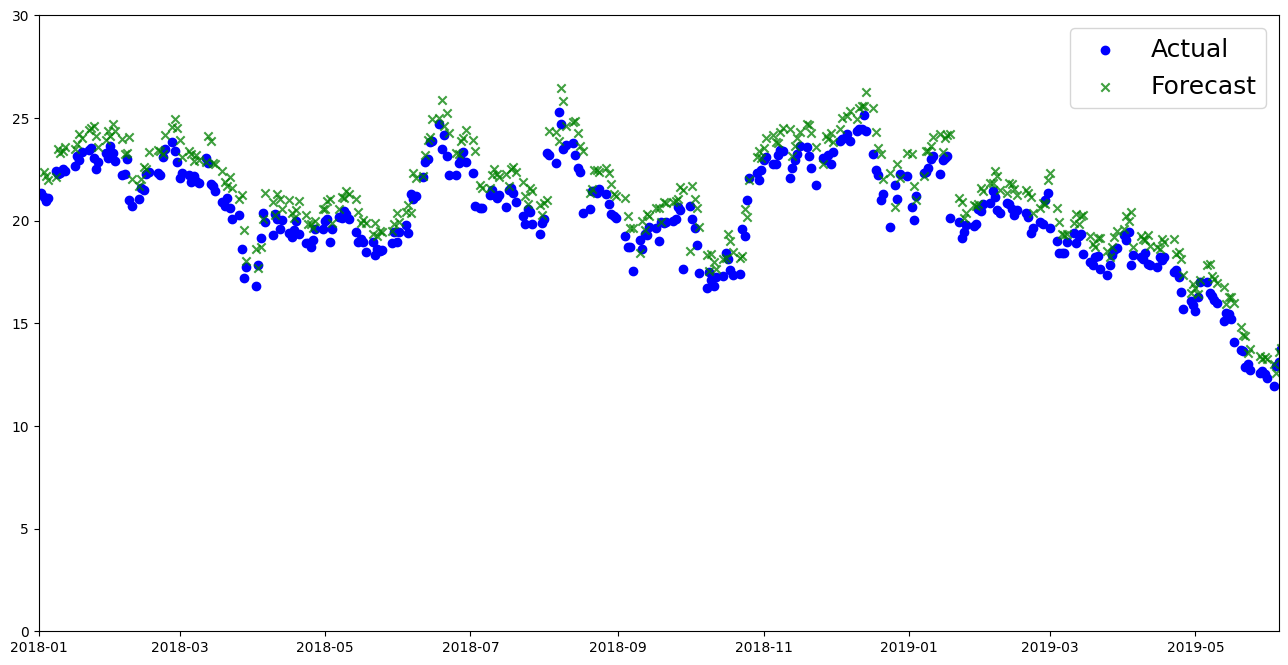

In [69]:
from datetime import datetime

#train
plt.scatter(df_prediction.index, df_prediction.Observed, 
            c = 'blue', label="Actual")
plt.scatter(df_prediction.index, df_prediction.Train_Prediction, 
            marker = 'x', c = 'green', alpha = 0.75, label="Forecast")
plt.legend(fontsize=18)
plt.xlim(datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.strptime('2019-06-05', '%Y-%m-%d'))
plt.ylim(0, 30)
plt.show()